In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
BASE_PATH = '/content/gdrive/MyDrive/Luận văn Cao học/Tuberculosis/TB_Chest_Radiography_Database/'

TEST_DIR = BASE_PATH + 'test/'
COLOR_MODE = 'rgb'
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE*5

test_set = image_dataset_from_directory(TEST_DIR,
                                            labels='inferred', 
                                            label_mode='int',
                                            color_mode=COLOR_MODE,
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMG_WIDTH, IMG_HEIGHT),
                                            seed=123)

Found 1400 files belonging to 2 classes.


# 1. Load model

In [4]:
BASE_PATH = '/content/gdrive/MyDrive/Luận văn Cao học/Tuberculosis/Models/Models for TB Chest Radiograph/'

model1 = keras.models.load_model(BASE_PATH + 'model_vgg16.h5')
model2 = keras.models.load_model(BASE_PATH + 'model_efficientnet.h5')
model3 = keras.models.load_model(BASE_PATH + 'model_mobilenetv3.h5')
model4 = keras.models.load_model(BASE_PATH + 'model_dense.h5')
model5 = keras.models.load_model(BASE_PATH + 'model_regnet.h5')

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Average

model_ensemble_1 = Model(inputs=model1.inputs,
                outputs=model1.outputs)

model_ensemble_2 = Model(inputs=model2.inputs,
                outputs=model2.outputs)

model_ensemble_3 = Model(inputs=model3.inputs,
                outputs=model3.outputs)

model_ensemble_4 = Model(inputs=model4.inputs,
                outputs=model4.outputs)

model_ensemble_5 = Model(inputs=model5.inputs,
                outputs=model5.outputs)

models = [model_ensemble_1, model_ensemble_2, model_ensemble_3, model_ensemble_4, model_ensemble_5]
models_input = Input(shape=(224, 224, 3))
models_outputs = [model(models_input) for model in models]

ensemble_output = Average()(models_outputs)

ensemble_model = Model(inputs=models_input, outputs=ensemble_output, name='ensemble')
ensemble_model.save('/content/gdrive/MyDrive/Luận văn Cao học/Tuberculosis/Models/Models for TB Chest Radiograph/model_ensemble.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sn
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def eval_model(model):
  acc = []
  precision = []
  recall = []
  cf = []
  f1 = []

  for img, label in test_set:
    y_pred = model.predict(img)
    y_pred = [1 if i > 0.5 else 0 for i in y_pred]
    acc.append(accuracy_score(label, y_pred))
    precision.append(precision_score(label, y_pred))
    recall.append(recall_score(label, y_pred))
    f1.append(f1_score(label, y_pred))
    cf.append(confusion_matrix(label, y_pred))

  print("Accuracy: " + str(np.mean(acc)))
  print("Precision: " + str(np.mean(precision)))
  print("Recall: " + str(np.mean(recall)))
  print("F1: " + str(np.mean(f1)))
  conf_matrix = np.sum(cf, axis=0)

  df_cm = pd.DataFrame(conf_matrix, index=['NORMAL', 'TUBECULOSIS'],
                       columns=['NORMAL', 'TUBERCULOSIS'])
  plt.figure(figsize=(10, 7))
  sn.set(font_scale=2)
  sn.heatmap(df_cm, annot=True, fmt='g')

# Đánh giá mô hình ensemble

Accuracy: 0.9806344696969697
Precision: 0.9984591679506933
Recall: 0.961869399975706
F1: 0.9796486635139204


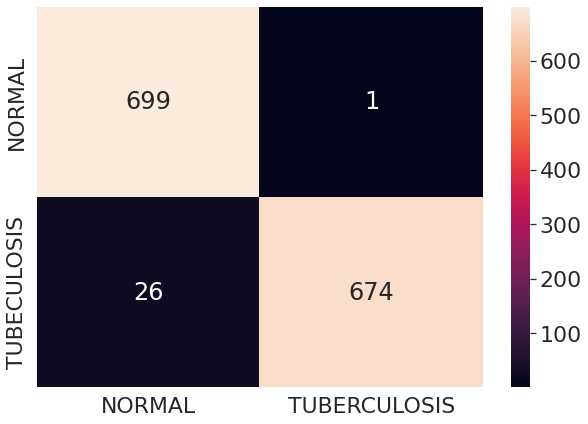

In [ ]:
eval_model(ensemble_model)